## GAAIMS: Predicting Multiple Sclerosis from Dynamics of Gait Variability Using an Instrumented Treadmill - A Machine Learning-Based Approach

### Feature importance - Trial and Person generalization best ML model


### Package imports 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
import os
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import copy
import itertools
from ast import literal_eval

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from inspect import signature
from scipy import interp
from sklearn.neural_network import MLPClassifier
from pyitlib import discrete_random_variable as drv
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings("ignore")

In [2]:
path = 'C:\\Users\\rk4\\Dropbox\\GAIT\\sample_data\\data_export\\'
#path = 'C:\\Users\\rk4\\Desktop\\GAIT\\' #For 3rd floor lab computers 

In [3]:
#Reading the Regress-N dataframe 
regressN_df = pd.read_csv(path+'..\\..\\FinalCodes\\csv files\\mr_scaled_features_30controlsTrialW.csv', index_col = 0)
regressN_df.reset_index(inplace= True)
print('Regress-N data shape: ', regressN_df.shape)
regressN_df.drop(['index'], axis = 1, inplace = True)
regressN_df = shuffle(regressN_df, random_state = 0)
print('Regress-N data shape: ', regressN_df.shape)  #21 features + PID + Trial ID + Label = 24 features 

Regress-N data shape:  (3230, 25)
Regress-N data shape:  (3230, 24)


## Trial Generalize

In [6]:
#Standardize the data before ML methods 
#Take care that testing set is not used while normalizaing the training set, otherwise the train set indirectly contains 
#information about the test set
def normalize(dataframe, n_type): 
    '''
    Input: dataframe, type of normalization (z-score or min-max)
    '''
    col_names = list(dataframe.columns)
    if (n_type == 'z'): #z-score normalization 
        mean = dataframe.mean()
        sd = dataframe.std()
    else: #min-max normalization
        mean = dataframe.min()
        sd = dataframe.max()-dataframe.min()
    return mean, sd

In [7]:
def evaluate(model, test_features, trueY):
    test_labels = trueY['Label'] #Dropping the PID
    predictions = model.predict(test_features)
    try:
        prediction_prob = model.predict_proba(test_features)[:, 1] #Score of the class with greater label
    except:
        prediction_prob = model.best_estimator_._predict_proba_lr(test_features)[:, 1] #For linear SVM 
    #Stride wise metrics 
    acc = accuracy_score(predictions, test_labels)
    p = precision_score(predictions, test_labels)
    r = recall_score(predictions, test_labels)
    f1 = f1_score(predictions, test_labels)
    auc = roc_auc_score(test_labels, prediction_prob)
    print('Stride-based model performance: ', acc, p, r, f1, auc)
    
    #For computing person wise metrics 
    temp = copy.deepcopy(trueY) #True label for the stride 
    temp['pred'] = predictions #Predicted label for the stride 
    #Correctly slassified strides i.e. 1 if stride is correctly classified and 0 if otherwise
    temp['correct'] = (temp['Label']==temp['pred'])

    #Proportion of correctly classified strides
    proportion_strides_correct = temp.groupby('PID').aggregate({'correct': 'mean'})  
    proportion_strides_correct['True Label'] = trueY.groupby('PID').first() 

    #Label for the person - 0=healthy, 1=MS patient
    proportion_strides_correct['Predicted Label'] = proportion_strides_correct['True Label']*\
    (proportion_strides_correct['correct']>0.5)+(1-proportion_strides_correct['True Label'])*\
    (proportion_strides_correct['correct']<0.5) 

    #Probability of class 1 - MS patient for AUC calculation
    proportion_strides_correct['prob_class1'] = (1-proportion_strides_correct['True Label'])*\
    (1-proportion_strides_correct['correct'])+ proportion_strides_correct['True Label']*proportion_strides_correct['correct'] 
    
    try:
        print (model.best_estimator_)
    except:
        pass
    #Person wise metrics 
    person_acc = accuracy_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label'])
    person_p = precision_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label'])
    person_r = recall_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label'])
    person_f1 = f1_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label'])
    person_auc = roc_auc_score(proportion_strides_correct['True Label'], proportion_strides_correct['prob_class1'])
    print('Person-based model performance: ', person_acc, person_p, person_r, person_f1, person_auc)
    return proportion_strides_correct['prob_class1'], [acc, p, r, f1, auc, person_acc, person_p, person_r, person_f1, person_auc]

In [8]:
#Best ML model with best parameters for trial generalize
best_model = GradientBoostingClassifier(learning_rate=0.15, max_depth=7, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=3, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150, random_state=0)

def models(trainX, trainY, testX, testY, model):
    '''
    training set: trainX, testX
    testing set: testX, testY
    model: model_name - best model for the feature importance case
    '''
    trainY1 = trainY['Label'] #Dropping the PID
    model.fit(trainX, trainY1) #Fitting on the training set to find the optimal hyperparameters 
    stride_person_metrics = evaluate(model, testX, testY)
    return stride_person_metrics

### Conditional entropies

In [65]:
#For conditional entropies, we need to discretize each feature into intervals an assign labels to their corresponding 
#binning interval 
#Assigning each value to it's corresponding interval by labelling it from 1 to interval_length 
def find_label(value, interval): 
    int_val = interval[1] - interval[0]
    label = 1
    for lower_bound in interval[0:]:
        upper_bound = lower_bound + int_val
        if ((lower_bound <= value) & (value < upper_bound)):
            return(label)
        label += 1
    return(label)

#converts a continous feature values array to a discrete feature labels array 
def continuous_to_discrete(array, num_interval):
    max_val = array.max()
    min_val = array.min()
    cur_interval = np.linspace(min_val, max_val + (0.000001 / num_interval), num_interval + 1)
    label_array = []
    for value in array:
        cur_index = find_label(value, cur_interval)
        label_array.append(cur_index)    
    return(label_array)

#### Trial W for conditional entropy

In [66]:
#Trial W for training 
#21 features for training data to compute conditional entropy for 
regressN_trial1 = regressN_df[regressN_df['TrialID']==1]
#Ordering the featuresaccording to paper's order
ordered_features = ['stride_time', 'swing_time', 'stance_time', 'SS_R', 'DS_R', 'DS_L', 'cadence',
       'stride_length', 'stride_width',  'LeftFPA', 'RightFPA', 'stride_speed',
       'walk_ratio', 'force_HSR', 'force_TOL', 'force_MidSSR', 'force_HSL', 'force_TOR', 'force_MidSSL',  'Butterfly_x_abs',
       'ButterflySQ_x', 'Label', 'PID', 'TrialID']
regressN_trial1 = regressN_trial1[ordered_features]
regressN_trainX = regressN_trial1.drop(['Label', 'PID', 'TrialID'], axis = 1) 
regressN_trainY = regressN_trial1[['PID', 'Label']]

#Trial WT for testing 
regressN_trial2 = regressN_df[regressN_df['TrialID']==2]
regressN_testX = regressN_trial2.drop(['Label', 'PID', 'TrialID'], axis = 1)
regressN_testY = regressN_trial2[['PID', 'Label']] #PID to compute person based metrics later 

#Normalize according to z-score standardization
norm_mean, norm_sd = normalize(regressN_trainX, 'z')
regressN_trainX_norm = (regressN_trainX-norm_mean)/norm_sd #Use this data for computing conditional entropies 
regressN_testX_norm = (regressN_testX-norm_mean)/norm_sd

In [67]:
# We select Regress-N data for trial generalize and only do conditional entropies on the training data set i.e. trial 1 features 
entropies=pd.DataFrame(index=regressN_trainX_norm.columns, columns = ['values'])
num_interval = 200
training_labels = np.array(regressN_trainY['Label'].values).astype('int')

for c in regressN_trainX_norm.columns.tolist():
    discrete_features = np.array(continuous_to_discrete(regressN_trainX_norm[c].values, num_interval)).astype('int')
    h=drv.entropy_conditional(training_labels, discrete_features)
    entropies.loc[c]=h
    
entropies_sorted= entropies.sort_values(by = 'values', ascending = False)
entropies.to_csv(path+ '..//trial_generalize//trial_generalize_conditional_entropies.csv')

In [68]:
feature_display_names = ['Stride time', 'Stance time', 'Swing time', 'Right SS', 'Initial DS', 
                         'Terminal DS', 'Cadence', 'Stride length', 'Stride width', 'Left FPA', 'Right FPA', 'Stride speed',
                           'Walk ratio', 'Force-HSR', 'Force-TOL', 'Force-MidSSR', 'Force-HSL',
                           'Force-TOR', 'Force-MidSSL', 'Lateral shift', 'Lateral deviation']
names = [r'$ST$', r'$S_tT$', r'$S_wT$', r'$SS_R$', r'$DS_T$',
       r'$DS_I$',  r'$C$', r'$SL$', r'$SW$', r'$\theta_L$', r'$\theta_R$', r'$SS$',
       r'$W$', r'$F_{HSR}$', r'$F_{TOL}$', r'$F_{MidSSR}$', r'$F_{HSL}$',
       r'$F_{TOR}$', r'$F_{MidSSL}$', r'$\beta_L$', r'$\alpha_L$']

feature_dic = {ordered_features[i]:feature_display_names[i] for i in range(21)}


#### Trial WT for conditional entropy

In [69]:
#Trial W for training 
#21 features for training data to compute conditional entropy for 
regressN_trial1 = regressN_df[regressN_df['TrialID']==2]
#Ordering the featuresaccording to paper's order
ordered_features = ['stride_time', 'swing_time', 'stance_time', 'SS_R', 'DS_R', 'DS_L', 'cadence',
       'stride_length', 'stride_width',  'LeftFPA', 'RightFPA', 'stride_speed',
       'walk_ratio', 'force_HSR', 'force_TOL', 'force_MidSSR', 'force_HSL', 'force_TOR', 'force_MidSSL',  'Butterfly_x_abs',
       'ButterflySQ_x', 'Label', 'PID', 'TrialID']
regressN_trial1 = regressN_trial1[ordered_features]
regressN_trainX = regressN_trial1.drop(['Label', 'PID', 'TrialID'], axis = 1) 
regressN_trainY = regressN_trial1[['PID', 'Label']]

#Trial WT for testing 
regressN_trial2 = regressN_df[regressN_df['TrialID']==2]
regressN_trial2 = regressN_trial2[ordered_features]
regressN_testX = regressN_trial2.drop(['Label', 'PID', 'TrialID'], axis = 1)
regressN_testY = regressN_trial2[['PID', 'Label']] #PID to compute person based metrics later 

#Normalize according to z-score standardization
norm_mean, norm_sd = normalize(regressN_trainX, 'z')
regressN_trainX_norm = (regressN_trainX-norm_mean)/norm_sd #Use this data for computing conditional entropies 

norm_mean_test, norm_sd_test = normalize(regressN_testX, 'z')
regressN_testX_norm = (regressN_testX-norm_mean_test)/norm_sd_test

In [70]:
# We select Regress-N data for trial generalize and only do conditional entropies on the training data set i.e. trial 1 features 
entropies2=pd.DataFrame(index=regressN_testX_norm.columns, columns = ['values'])
num_interval = 200
training_labels = np.array(regressN_testY['Label'].values).astype('int')

for c in regressN_testX_norm.columns.tolist():
    discrete_features = np.array(continuous_to_discrete(regressN_testX_norm[c].values, num_interval)).astype('int')
    h=drv.entropy_conditional(training_labels, discrete_features)
    entropies2.loc[c]=h
    
entropies_sorted2= entropies2.sort_values(by = 'values', ascending = False)
entropies2.to_csv(path+ '..//trial_generalize//trial_generalize_conditional_entropies_trialWT.csv')

In [71]:
feature_display_names = ['Stride time', 'Stance time', 'Swing time', 'Right SS', 'Initial DS', 
                         'Terminal DS', 'Cadence', 'Stride length', 'Stride width', 'Left FPA', 'Right FPA', 'Stride speed',
                           'Walk ratio', 'Force-HSR', 'Force-TOL', 'Force-MidSSR', 'Force-HSL',
                           'Force-TOR', 'Force-MidSSL', 'Lateral shift', 'Lateral deviation']
names = [r'$ST$', r'$S_tT$', r'$S_wT$', r'$SS_R$', r'$DS_T$',
       r'$DS_I$',  r'$C$', r'$SL$', r'$SW$', r'$\theta_L$', r'$\theta_R$', r'$SS$',
       r'$W$', r'$F_{HSR}$', r'$F_{TOL}$', r'$F_{MidSSR}$', r'$F_{HSL}$',
       r'$F_{TOR}$', r'$F_{MidSSL}$', r'$\beta_L$', r'$\alpha_L$']

feature_dic = {ordered_features[i]:feature_display_names[i] for i in range(21)}


In [72]:
#Adding different colors in CE plot for differeent feature types 
#Spatial - yellow, Temporal - blue, spatiotemporal - green, kinetic - red

ordered_features = ['stride_time', 'swing_time', 'stance_time', 'SS_R', 'DS_R', 'DS_L', 'cadence',
       'stride_length', 'stride_width',  'LeftFPA', 'RightFPA', 'stride_speed',
       'walk_ratio', 'force_HSR', 'force_TOL', 'force_MidSSR', 'force_HSL', 'force_TOR', 'force_MidSSL',  'Butterfly_x_abs',
       'ButterflySQ_x', 'Label', 'PID', 'TrialID']

colors = ['#66b3ff', '#66b3ff', '#66b3ff', '#66b3ff', '#66b3ff', '#66b3ff', '#66b3ff']+ \
         4*['palegreen']+2*['plum'] + 8*['salmon']

color_dic = {ordered_features[i]:colors[i] for i in range(21)}

In [73]:
colors.reverse()
entropies = entropies.iloc[::-1]
entropies2 = entropies2.iloc[::-1]

entropies['colors'] = colors
entropies = entropies.sort_values(by = ['colors', 'values'], ascending= False)

entropies2['colors'] = colors
entropies2 = entropies2.sort_values(by = ['colors', 'values'], ascending= False)

In [74]:
regressN_testX_norm.columns

Index(['stride_time', 'swing_time', 'stance_time', 'SS_R', 'DS_R', 'DS_L',
       'cadence', 'stride_length', 'stride_width', 'LeftFPA', 'RightFPA',
       'stride_speed', 'walk_ratio', 'force_HSR', 'force_TOL', 'force_MidSSR',
       'force_HSL', 'force_TOR', 'force_MidSSL', 'Butterfly_x_abs',
       'ButterflySQ_x'],
      dtype='object')

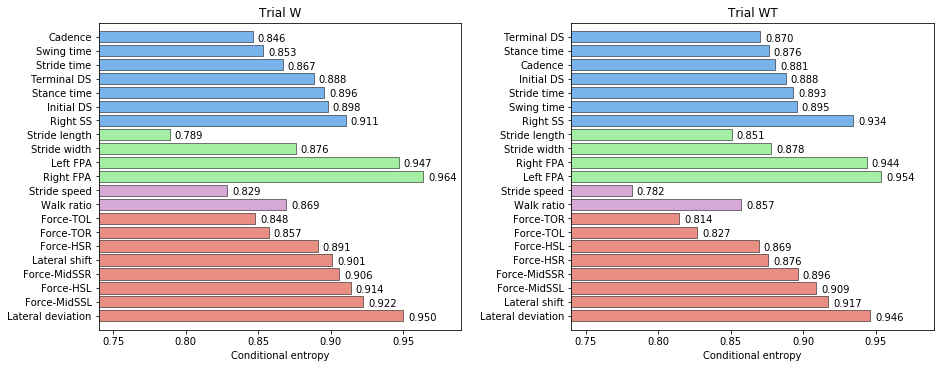

In [75]:
mpl.rcParams['axes.spines.top'] = True
mpl.rcParams['axes.spines.right'] = True

fig, axes = plt.subplots(1, 2, sharex=True, sharey = False, figsize=(13, 5), constrained_layout=True)
# fig.tight_layout()
# sns.despine(offset=0)
# colors_sorted = [color_dic[x] for x in entropies_sorted.index]
sns.barplot(x = 'values', y = entropies.index, data=entropies,  palette= colors, linewidth = 0.5, \
                 edgecolor = 'k', ax = axes[0])
#palette= colors_sorted, #use for colored plot
feature_display_names_sorted = [feature_dic[x] for x in entropies.index]
for p in axes[0].patches:
    axes[0].annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()-0.35),
                xytext=(5, 6), textcoords='offset points')
    
axes[0].set_yticks(np.arange(21))
axes[0].set_yticklabels(feature_display_names_sorted)
axes[0].set_ylim(-1,21)
axes[0].set_xlim(0.74, 0.99)
axes[0].set_xlabel('Conditional entropy')
axes[0].set_title('Trial W')

colors_sorted2 = [color_dic[x] for x in entropies_sorted2.index]
sns.barplot(x = 'values', y = entropies2.index, data=entropies2, palette= colors, linewidth = 0.5, \
                 edgecolor = 'k', ax = axes[1])
feature_display_names_sorted2 = [feature_dic[x] for x in entropies2.index]

for p in axes[1].patches:
    axes[1].annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()-0.35),
                xytext=(5, 6), textcoords='offset points')
    
axes[1].set_yticks(np.arange(21))
axes[1].set_yticklabels(feature_display_names_sorted2)
axes[1].set_ylim(-1,21)
axes[1].set_xlim(0.74, 0.99)
axes[1].set_xlabel('Conditional entropy')
axes[1].set_title('Trial WT')

# plt.title('Feature conditional entropies')
plt.savefig(path+ '..//trial_generalize//Conditional_entropies_trialWandWT_colored_sorted.png', dpi = 250, bbox_inches='tight')
plt.show()

In [218]:
entropies_trialWandWT = pd.concat([entropies_sorted, entropies_sorted2], axis = 1)
entropies_trialWandWT.columns = ['trialW', 'trialWT']

In [468]:
(entropies_trialWandWT['trialW']<entropies_trialWandWT['trialWT']).sum()

8

#### Both trials together in conditional entropy

In [115]:
#Trial W and WT together 
#Trial W for training 
#21 features for training data to compute conditional entropy for 
regressN= regressN_df
#Ordering the featuresaccording to paper's order
ordered_features = ['stride_time', 'swing_time', 'stance_time', 'SS_R', 'DS_R', 'DS_L', 'cadence',
       'stride_length', 'stride_width',  'LeftFPA', 'RightFPA', 'stride_speed',
       'walk_ratio', 'force_HSR', 'force_TOL', 'force_MidSSR', 'force_HSL', 'force_TOR', 'force_MidSSL',  'Butterfly_x_abs',
       'ButterflySQ_x', 'Label', 'PID', 'TrialID']
regressN = regressN[ordered_features]
regressN_trainX = regressN.drop(['Label', 'PID', 'TrialID'], axis = 1) 
regressN_trainY = regressN[['PID', 'Label']]


#Normalize according to z-score standardization
norm_mean, norm_sd = normalize(regressN_trainX, 'z')
regressN_trainX_norm = (regressN_trainX-norm_mean)/norm_sd #Use this data for computing conditional entropies 

In [116]:
# We select Regress-N data for trial generalize and only do conditional entropies on the training data set i.e. trial 1 features 
entropies3=pd.DataFrame(index=regressN_trainX_norm.columns, columns = ['values'])
num_interval = 200
training_labels = np.array(regressN_trainY['Label'].values).astype('int')

for c in regressN_trainX_norm.columns.tolist():
    discrete_features = np.array(continuous_to_discrete(regressN_trainX_norm[c].values, num_interval)).astype('int')
    h=drv.entropy_conditional(training_labels, discrete_features)
    entropies3.loc[c]=h
    
entropies_sorted3= entropies3.sort_values(by = 'values', ascending = False)
entropies3.to_csv(path+ '..//trial_generalize//Conditional_entropies_both_trial_together.csv')

In [117]:
feature_display_names = ['Stride time', 'Stance time', 'Swing time', 'Right SS', 'Initial DS', 
                         'Terminal DS', 'Cadence', 'Stride length', 'Stride width', 'Left FPA', 'Right FPA', 'Stride speed',
                           'Walk ratio', 'Force-HSR', 'Force-TOL', 'Force-MidSSR', 'Force-HSL',
                           'Force-TOR', 'Force-MidSSL', 'Lateral shift', 'Lateral deviation']
names = [r'$ST$', r'$S_tT$', r'$S_wT$', r'$SS_R$', r'$DS_T$',
       r'$DS_I$',  r'$C$', r'$SL$', r'$SW$', r'$\theta_L$', r'$\theta_R$', r'$SS$',
       r'$W$', r'$F_{HSR}$', r'$F_{TOL}$', r'$F_{MidSSR}$', r'$F_{HSL}$',
       r'$F_{TOR}$', r'$F_{MidSSL}$', r'$\beta_L$', r'$\alpha_L$']

feature_dic = {ordered_features[i]:feature_display_names[i] for i in range(21)}


In [118]:
entropies3 = entropies3.iloc[::-1]

entropies3['colors'] = colors
entropies3 = entropies3.sort_values(by = ['colors', 'values'], ascending= False)

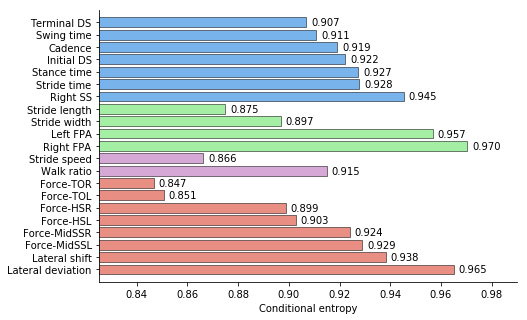

In [119]:
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

plt.figure(figsize=(7.5, 5))
# fig.tight_layout()
# sns.despine(offset=0)
colors_sorted3 = [color_dic[x] for x in entropies_sorted3.index]
ax = sns.barplot(x = 'values', y = entropies_sorted3.index, data=entropies3, palette= colors, linewidth = 0.5, \
                 edgecolor = 'k')
feature_display_names_sorted = [feature_dic[x] for x in entropies3.index]
for p in ax.patches:
    ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()-0.35),
                xytext=(5, 6), textcoords='offset points')
    
ax.set_yticks(np.arange(21))
ax.set_yticklabels(feature_display_names_sorted)
ax.set_ylim(-1,21)
ax.set_xlim(0.825, 0.99)
ax.set_xlabel('Conditional entropy')
# ax.set_title('Feature conditional entropies')
# plt.title('Feature conditional entropies')
plt.savefig(path+ '..//trial_generalize//Conditional_entropies__both_trial_together_colored_sorted.png', dpi = 350, bbox_inches='tight')
plt.show()

### Feature importance of different data streams for the best ML model in trial generalize case for regress-N data

In [370]:
spatial_features = ['stride_length', 'stride_width', 'LeftFPA', 'RightFPA']
temporal_features = ['stride_time', 'swing_time', 'stance_time', 'SS_R', 'DS_L', 'DS_R', 'cadence' ]
spatiotemporal = ['stride_speed', 'walk_ratio']
kinetic_features = ['force_HSR', 'force_MidSSR', 'force_TOR', 'force_HSL', 'force_TOL', 'force_MidSSL', 'Butterfly_x_abs', 'ButterflySQ_x']
wearable_features = regressN_trainX.columns.drop(['Butterfly_x_abs', 'ButterflySQ_x'])

datastreams = {'spatial': spatial_features, 'temporal': temporal_features, 'kinetic': kinetic_features, 
        'spatiotemporal': spatial_features+temporal_features+spatiotemporal, 'spatial_kinetic': spatial_features+kinetic_features,\
       'temporal_kinetic':  temporal_features+kinetic_features, 'wearable': wearable_features, \
               'all': spatial_features+temporal_features+spatiotemporal+kinetic_features}

fi_columns = list(itertools.product(['GBM'],datastreams))
regressN_metrics = pd.DataFrame(columns = fi_columns) #Dataframe to store accuracies for each ML model for raw data 

for col in fi_columns:
    print (col)
    datastream = datastreams[col[1]]
#     print (regressN_trainX_norm[datastream].head())
    _, stride_person_metrics = models(regressN_trainX_norm[datastream], regressN_trainY, regressN_testX_norm[datastream], regressN_testY, best_model)
    regressN_metrics[col] = stride_person_metrics
    print ('********************************')

regressN_metrics.index = ['stride_accuracy', 'stride_precision', 'stride_recall', 'stride_F1', 'stride_AUC', 'person_accuracy', 
                     'person_precision', 'person_recall', 'person_F1', 'person_AUC']  
regressN_metrics.to_csv(path+'..//trial_generalize//trial_generalize_feature_importance_regressN_BestModelGBM.csv')

('GBM', 'spatial')
Stride-based model performance:  0.6687817258883249 0.5888252148997135 0.6362229102167183 0.6116071428571429 0.7193347736128607
Person-based model performance:  0.7142857142857143 0.5882352941176471 0.7692307692307693 0.6666666666666667 0.8562091503267973
********************************
('GBM', 'temporal')
Stride-based model performance:  0.666243654822335 0.5959885386819485 0.6303030303030303 0.6126656848306333 0.7400072449106135
Person-based model performance:  0.8285714285714286 0.7647058823529411 0.8666666666666667 0.8125 0.9084967320261438
********************************
('GBM', 'kinetic')
Stride-based model performance:  0.7189086294416244 0.6160458452722063 0.7107438016528925 0.6600153491941673 0.7941417391701641
Person-based model performance:  0.8285714285714286 0.7058823529411765 0.9230769230769231 0.8000000000000002 0.9444444444444445
********************************
('GBM', 'spatiotemporal')
Stride-based model performance:  0.7703045685279187 0.73638968

In [40]:
regressN_metrics = pd.read_csv(path+'..//trial_generalize//trial_generalize_feature_importance_regressN_BestModelGBM.csv')
regressN_metrics.index = regressN_metrics['Unnamed: 0']
regressN_metrics.drop('Unnamed: 0', axis = 1, inplace = True)

In [41]:
#Interchanging Precision and Recall values 
temp1 = regressN_metrics.iloc[1].copy()
regressN_metrics.iloc[1] = regressN_metrics.iloc[2]
regressN_metrics.iloc[2] = temp1

temp2 = regressN_metrics.iloc[6].copy()
regressN_metrics.iloc[6] = regressN_metrics.iloc[7]
regressN_metrics.iloc[7] = temp2

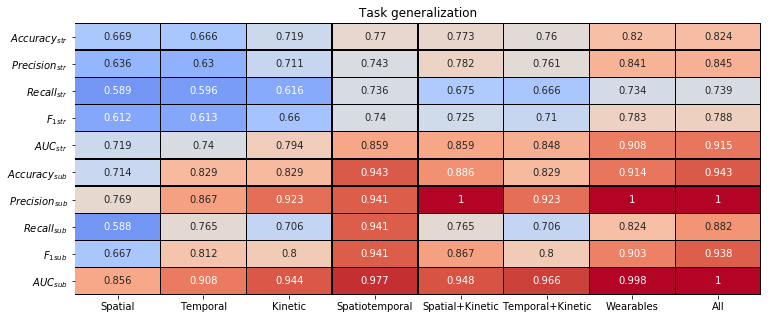

In [42]:
#Heatmaps 
plt.figure(figsize = (12.3, 5))
xticklabels= ['Spatial', 'Temporal', 'Kinetic', 'Spatiotemporal', 'Spatial+Kinetic', 'Temporal+Kinetic', 'Wearables', 'All']
yticklabels = [r'$Accuracy_{str}$', r'$Precision_{str}$', r'$Recall_{str}$', r'$F_{1{str}}$', r'$AUC_{str}$', r'$Accuracy_{sub}$', r'$Precision_{sub}$',\
               r'$Recall_{sub}$', r'$F_{1{sub}}$', r'$AUC_{sub}$']
sns.heatmap(regressN_metrics, vmin=0.5, vmax=1, center = 0.75, cmap="coolwarm", annot=True, xticklabels=xticklabels, 
           yticklabels=yticklabels, linewidths=0.4, linecolor="k", cbar = False, fmt='.3g')
plt.title('Task generalization')
plt.ylabel('')
plt.savefig(path + '..//trial_generalize//heatmap_feature_importance.jpg', dpi = 250, bbox_inches='tight')
plt.show()

In [97]:
fi_sorted_walkAUC = regressN_metrics.loc['person_AUC'].sort_values()
fi_sorted_walkAUC.index

Index(['('GBM', 'spatial')', '('GBM', 'temporal')', '('GBM', 'kinetic')',
       '('GBM', 'spatial_kinetic')', '('GBM', 'temporal_kinetic')',
       '('GBM', 'spatiotemporal')', '('GBM', 'wearable')', '('GBM', 'all')'],
      dtype='object')

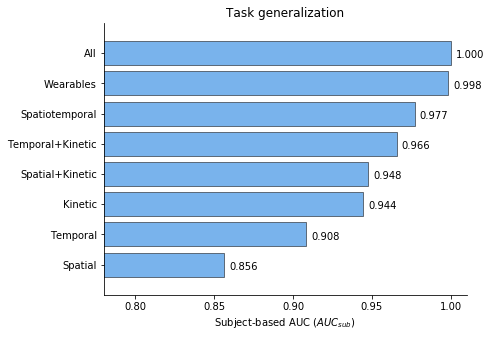

In [57]:
fi_sorted_walkAUC = regressN_metrics.loc['person_AUC'].sort_values()

data_display_names = {regressN_metrics.columns[i]:xticklabels[i] for i in range(8)}
data_display_names_sorted = [data_display_names[x] for x in fi_sorted_walkAUC.index]

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

plt.figure(figsize = (6.5, 5))
sns.despine(offset=1)
ax = sns.barplot(x = fi_sorted_walkAUC.values, y = fi_sorted_walkAUC.index, color ='#66b3ff', linewidth = 0.5, \
                 edgecolor = 'k')
for p in ax.patches:
    ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(5, 7), textcoords='offset points')
# plt.axvline(x=1, color = 'r', alpha = 0.7)

plt.yticks(np.arange(8), data_display_names_sorted)
plt.ylim(-1,8)
plt.xlim(0.78, max(fi_sorted_walkAUC.values)+0.01)
plt.xlabel(r'Subject-based AUC ($AUC_{sub}$)')
plt.title('Task generalization')
plt.savefig(path+ '..//trial_generalize//trial_generalize_feature_importance_barplot_all8data.png', dpi = 250, bbox_inches='tight')
plt.show()

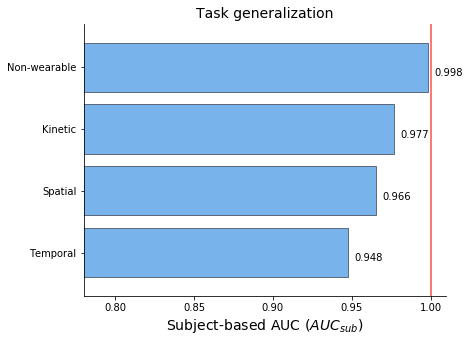

In [74]:
fi_sorted_walkAUC_reduced = regressN_metrics.loc['person_AUC'][3:7].sort_values()

reduced_labels = ['T+K', 'S+K', 'S+T', 'Kinetic', 'Temporal', 'Spatial', 'Non-wearable', 'All']
data_display_names = {regressN_metrics.columns[i]:reduced_labels[i] for i in range(8)}
data_display_names_sorted = [data_display_names[x] for x in fi_sorted_walkAUC_reduced.index]
plt.rcParams['font.size'] = 10
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

plt.figure(figsize = (6.5, 5))
sns.despine(offset=1)
ax = sns.barplot(x = fi_sorted_walkAUC_reduced.values, y = fi_sorted_walkAUC_reduced.index, color ='#66b3ff', linewidth = 0.5, \
                 edgecolor = 'k')
for p in ax.patches:
    ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(6, 16), textcoords='offset points')
plt.axvline(x=1, color = 'r', alpha = 0.7)

plt.yticks(np.arange(4), data_display_names_sorted)
plt.ylim(-0.7,3.7)
plt.xlim(0.78, max(fi_sorted_walkAUC.values)+0.01)
plt.xlabel(r'Subject-based AUC ($AUC_{sub}$)', fontsize = 14)
plt.title('Task generalization', fontsize = 14)
plt.savefig(path+ '..//trial_generalize//trial_generalize_feature_importance_barplot_reduced_data.png', dpi = 250, bbox_inches='tight')
plt.show()

## People generalize

In [29]:
def acc(y_true,y_pred):
    global yoriginal, ypredicted
    yoriginal.append(y_true)
    ypredicted.append(y_pred)
    accuracy = accuracy_score(y_true, y_pred)
#     print ('Stride accuracy at this CV grid search = ', accuracy)
    return accuracy


def evaluate_subject_generalize(model, test_features, yoriginal_, ypredicted_):
    prop_strides_appended = pd.DataFrame()
    best_index = model.cv_results_['mean_test_accuracy'].argmax()
    print('best_params: ', model.cv_results_['params'][best_index])

    #Stride-wise metrics 
    stride_metrics_mean, stride_metrics_std = [], [] #Mean and SD of stride based metrics - Acc, P, R, F1, AUC (in order)
    scores={'accuracy': make_scorer(acc), 'precision':'precision', 'recall':'recall', 'f1': 'f1', 'auc': 'roc_auc'}
    for score in scores:
        stride_metrics_mean.append(model.cv_results_['mean_test_'+score][best_index])
        stride_metrics_std.append(model.cv_results_['std_test_'+score][best_index])
    print('Stride-based model performance (mean): ', stride_metrics_mean)
    print('Stride-based model performance (standard deviation): ', stride_metrics_std)
    n_folds = 7
    person_acc, person_p, person_r, person_f1, person_auc = [], [], [], [], []
    #For ROC curves 
    tpr_list = []
    base_fpr = np.linspace(0, 1, 101)

    for i in range(n_folds):
        #For each fold, there are 2 splits: test and train (in order) and we need to retrieve the index 
        #of only test set for required 5 folds (best index)
#         print ((best_index*n_folds) + (i))
        temp = test_features.loc[yoriginal_[(best_index*n_folds) + (i)].index] #True labels for the test strides in each fold
        temp['pred'] = ypredicted_[(best_index*n_folds) + (i)] #Predicted labels for the strides in the test set in each fold

        #Correctly classified strides i.e. 1 if stride is correctly classified and 0 if otherwise
        temp['correct'] = (temp['Label']==temp['pred'])
        
#         print (temp)
        #Proportion of correctly classified strides
        proportion_strides_correct = temp.groupby('PID').aggregate({'correct': 'mean'})  

        proportion_strides_correct['True Label'] = temp[['PID', 'Label']].groupby('PID').first() 
        
#         print ('Proportion correct', proportion_strides_correct)
        prop_strides_appended= prop_strides_appended.append(proportion_strides_correct)
#         print ('append', prop_strides_appended)
        #Label for the person - 0=healthy, 1=MS patient
        proportion_strides_correct['Predicted Label'] = proportion_strides_correct['True Label']*\
        (proportion_strides_correct['correct']>=0.495)+(1-proportion_strides_correct['True Label'])*\
        (proportion_strides_correct['correct']<0.495) 

        #Probability of class 1 - MS patient for AUC calculation
        proportion_strides_correct['prob_class1'] = (1-proportion_strides_correct['True Label'])*\
        (1-proportion_strides_correct['correct'])+ proportion_strides_correct['True Label']*proportion_strides_correct['correct'] 

        fpr, tpr, _ = roc_curve(proportion_strides_correct['True Label'], proportion_strides_correct['prob_class1'])
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tpr_list.append(tpr)

#         print (proportion_strides_correct)
        #Person wise metrics for each fold 
        person_acc.append(accuracy_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label']))
        person_p.append(precision_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label']))
        person_r.append(recall_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label']))
        person_f1.append(f1_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label']))
        person_auc.append(roc_auc_score(proportion_strides_correct['True Label'], proportion_strides_correct['prob_class1']))

    #Mean and standard deviation for person-based metrics 
    person_means = [np.mean(person_acc), np.mean(person_p), np.mean(person_r), np.mean(person_f1), np.mean(person_auc)]
    person_stds = [np.std(person_acc), np.std(person_p), np.std(person_r), np.std(person_f1), np.std(person_auc)]
    print('Person-based model performance (mean): ', person_means)
    print('Person-based model performance (standard deviation): ', person_stds)
#     prop_strides_appended.to_csv(path+'..//person_generalize//prop_strides_appeneded_adaboost.csv')
    return tpr_list, [stride_metrics_mean, stride_metrics_std, person_means, person_stds]

In [30]:
#We do not use LDA/QDA since our features are not normally distributed 
def models_subject_generalize(X, Y):
    '''
    X, Y, PID groups so that strides of each person are either in training or in testing set
    model: model_name
    '''
    Y_ = Y['Label'] #Dropping the PID
    groups_ = Y['PID']
    gkf = GroupKFold(n_splits=7) 
    scores={'accuracy': make_scorer(acc), 'precision':'precision', 'recall':'recall', 'f1': 'f1', 'auc': 'roc_auc'}

    mlp_grid = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(42, 5, 21, 21, 21, 5, 120), activation='relu', solver='adam' , \
                                                            learning_rate = 'adaptive', learning_rate_init=0.001, \
                                                             shuffle=False, max_iter = 200))
    grid = {
    'mlpclassifier__random_state': [0], 
    }
    grid_search = GridSearchCV(mlp_grid, param_grid=grid, scoring=scores\
                   , n_jobs = 1, cv=gkf.split(X, Y_, groups=groups_), refit=False, verbose=0)  #0.79 good accuracy and F1 
    
    grid_search.fit(X, Y_, groups=groups_) #Fitting on the training set to find the optimal hyperparameters 
    tpr_list, stride_person_metrics = evaluate_subject_generalize(grid_search, Y, yoriginal, ypredicted)
    return tpr_list, stride_person_metrics

### Feature importance of different data streams for the best ML model in trial generalize case for regress-N data

In [25]:
X_regressN_investigate = regressN_df.drop(['Label', 'PID', 'TrialID'], axis = 1)
Y_regressN_investigate = regressN_df[['PID', 'Label']] #PID to compute person based metrics later 

spatial_features = ['stride_length', 'stride_width', 'LeftFPA', 'RightFPA']
temporal_features = ['stride_time', 'swing_time', 'stance_time', 'SS_R', 'DS_L', 'DS_R', 'cadence' ]
spatiotemporal = ['stride_speed', 'walk_ratio']
kinetic_features = ['force_HSR', 'force_MidSSR', 'force_TOR', 'force_HSL', 'force_TOL', 'force_MidSSL', 'Butterfly_x_abs', 'ButterflySQ_x']
wearable_features = X_regressN_investigate.columns.drop(['Butterfly_x_abs', 'ButterflySQ_x'])

datastreams = {'spatial': spatial_features, 'temporal': temporal_features, 'kinetic': kinetic_features, 
        'spatiotemporal': spatial_features+temporal_features+spatiotemporal, 'spatial_kinetic': spatial_features+kinetic_features,\
       'temporal_kinetic':  temporal_features+kinetic_features, 'wearable': wearable_features, \
               'all': spatial_features+temporal_features+spatiotemporal+kinetic_features}

fi_columns = list(itertools.product(['MLP'],datastreams))
regressN_metrics = pd.DataFrame(columns = fi_columns) #Dataframe to store accuracies for each ML model for raw data 


for col in fi_columns:
    print (col)
    datastream = datastreams[col[1]]
    yoriginal = []
    ypredicted = []
#     print (regressN_trainX_norm[datastream].head())
    if (col[1] == 'all'):
        X = X_regressN_investigate
    else:
        X = X_regressN_investigate[datastream]
    _, stride_person_metrics = models_subject_generalize(X, Y_regressN_investigate)
    regressN_metrics[col] = sum(stride_person_metrics, [])
    print ('********************************')

regressN_metrics.index = ['stride_accuracy_mean', 'stride_precision_mean', 'stride_recall_mean', 'stride_F1_mean', \
                          'stride_AUC_mean', 'stride_accuracy_std', 'stride_precision_std', 'stride_recall_std', \
                          'stride_F1_std', 'stride_AUC_std', 'person_accuracy_mean', \
                     'person_precision_mean', 'person_recall_mean', 'person_F1_mean', 'person_AUC_mean', \
                      'person_accuracy_std', 'person_precision_std', 'person_recall_std', 'person_F1_std', \
                          'person_AUC_std']  
regressN_metrics.to_csv('subject_generalize_feature_importance_regressN_BestModelMLP.csv')

('MLP', 'spatial')
best_params:  {'mlpclassifier__random_state': 0}
Stride-based model performance (mean):  [0.5012383900928793, 0.41580553865471537, 0.3126831530602242, 0.3447200166510383, 0.45038537419050734]
Stride-based model performance (standard deviation):  [0.06567531943452866, 0.2345415706834106, 0.11925398526247599, 0.14516220544682445, 0.14106771124797435]
Person-based model performance (mean):  [0.48571428571428577, 0.17857142857142858, 0.35714285714285715, 0.22380952380952382, 0.46428571428571436]
Person-based model performance (standard deviation):  [0.18070158058105026, 0.22015764296317772, 0.44031528592635544, 0.26827744801911, 0.21756746288686984]
********************************
('MLP', 'temporal')
best_params:  {'mlpclassifier__random_state': 0}
Stride-based model performance (mean):  [0.5823529411764706, 0.5432755176301933, 0.43193728598472286, 0.46949854797607715, 0.6331388041634836]
Stride-based model performance (standard deviation):  [0.1498952222486285, 0.26758

In [50]:
regressN_metrics_subject_generalize = pd.read_csv(path + '..//..//subject_generalize_feature_importance_regressN_BestModelMLP.csv')
regressN_metrics_subject_generalize.index = regressN_metrics_subject_generalize['Unnamed: 0']
regressN_metrics_subject_generalize.drop('Unnamed: 0', axis = 1, inplace = True)

regressN_metrics_subject_generalize

,"('MLP', 'spatial')","('MLP', 'temporal')","('MLP', 'kinetic')","('MLP', 'spatiotemporal')","('MLP', 'spatial_kinetic')","('MLP', 'temporal_kinetic')","('MLP', 'wearable')","('MLP', 'all')"
Unnamed: 0,,,,,,,,
stride_accuracy_mean,0.501238,0.582353,0.563158,0.529102,0.462539,0.541486,0.548297,0.621053
stride_precision_mean,0.415806,0.543276,0.543617,0.484708,0.397089,0.501112,0.532141,0.579499
stride_recall_mean,0.312683,0.431937,0.449148,0.460517,0.391529,0.398544,0.490910,0.619158
stride_F1_mean,0.344720,0.469499,0.444151,0.446436,0.345288,0.412938,0.459864,0.564603
stride_AUC_mean,0.450385,0.633139,0.585703,0.558047,0.445779,0.580276,0.571613,0.682426
stride_accuracy_std,0.065675,0.149895,0.154096,0.071762,0.117207,0.140076,0.128496,0.097508
stride_precision_std,0.234542,0.267585,0.248290,0.258487,0.245874,0.248997,0.239640,0.223449
stride_recall_std,0.119254,0.171527,0.237779,0.155600,0.274249,0.198946,0.230676,0.199366
stride_F1_std,0.145162,0.203221,0.199987,0.148592,0.200284,0.190144,0.174525,0.140435


### Vizualizations for subject-generality model 

### Remember to interchange subject-based precision and recall 

In [52]:
#Interchanging subject Precision and Recall values 
temp1 = regressN_metrics_subject_generalize.iloc[11].copy()
regressN_metrics_subject_generalize.iloc[11] = regressN_metrics_subject_generalize.iloc[12]
regressN_metrics_subject_generalize.iloc[12] = temp1

temp1 = regressN_metrics_subject_generalize.iloc[16].copy()
regressN_metrics_subject_generalize.iloc[16] = regressN_metrics_subject_generalize.iloc[17]
regressN_metrics_subject_generalize.iloc[17] = temp1

In [53]:
regressN_metrics_subject_generalize.index

Index(['stride_accuracy_mean', 'stride_precision_mean', 'stride_recall_mean',
       'stride_F1_mean', 'stride_AUC_mean', 'stride_accuracy_std',
       'stride_precision_std', 'stride_recall_std', 'stride_F1_std',
       'stride_AUC_std', 'person_accuracy_mean', 'person_precision_mean',
       'person_recall_mean', 'person_F1_mean', 'person_AUC_mean',
       'person_accuracy_std', 'person_precision_std', 'person_recall_std',
       'person_F1_std', 'person_AUC_std'],
      dtype='object', name='Unnamed: 0')

In [54]:
#Dropping standard deviation values 
std_rows = ['stride_accuracy_std', 'stride_precision_std', 'stride_recall_std', 'stride_F1_std',
       'stride_AUC_std', 'person_accuracy_std', 'person_precision_std', 'person_recall_std',
       'person_F1_std', 'person_AUC_std']
regressN_metrics_subject_generalize.drop(std_rows, inplace= True)

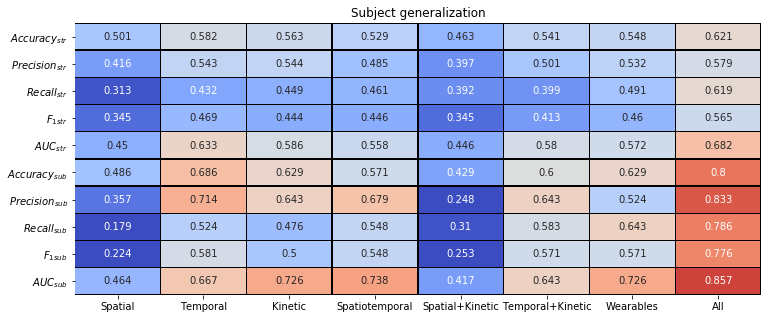

In [55]:
#Heatmaps 
plt.figure(figsize = (12.3, 5))
xticklabels= ['Spatial', 'Temporal', 'Kinetic', 'Spatiotemporal', 'Spatial+Kinetic', 'Temporal+Kinetic', 'Wearables', 'All']
yticklabels = [r'$Accuracy_{str}$', r'$Precision_{str}$', r'$Recall_{str}$', r'$F_{1{str}}$', r'$AUC_{str}$', r'$Accuracy_{sub}$', r'$Precision_{sub}$',\
               r'$Recall_{sub}$', r'$F_{1{sub}}$', r'$AUC_{sub}$']
sns.heatmap(regressN_metrics_subject_generalize, vmin=0.3, vmax=0.9, center = 0.6, cmap="coolwarm", annot=True, xticklabels=xticklabels, 
           yticklabels=yticklabels, linewidths=0.4, linecolor="k", cbar = False, fmt='.3g')
plt.title('Subject generalization')
plt.ylabel('')
plt.savefig(path + '..//person_generalize//heatmap_feature_importance_subjectMLP.jpg', dpi = 250, bbox_inches='tight')
plt.show()

In [56]:
fi_sorted_walkAUC_subject_generalize = regressN_metrics_subject_generalize.loc['person_AUC_mean'].sort_values()
fi_sorted_walkAUC_subject_generalize.index

Index(['('MLP', 'spatial_kinetic')', '('MLP', 'spatial')',
       '('MLP', 'temporal_kinetic')', '('MLP', 'temporal')',
       '('MLP', 'wearable')', '('MLP', 'kinetic')',
       '('MLP', 'spatiotemporal')', '('MLP', 'all')'],
      dtype='object')

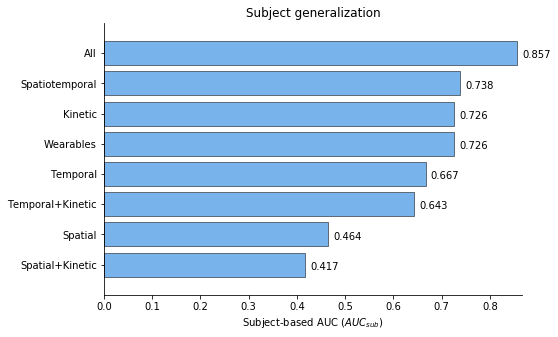

In [140]:
fi_sorted_walkAUC_subject_generalize2 = regressN_metrics_subject_generalize.loc['person_AUC_mean'].sort_values()

data_display_names = {regressN_metrics_subject_generalize.columns[i]:xticklabels[i] for i in range(8)}
data_display_names_sorted = [data_display_names[x] for x in fi_sorted_walkAUC_subject_generalize2.index]

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

plt.figure(figsize = (7.5, 5))
sns.despine(offset=1)
ax = sns.barplot(x = fi_sorted_walkAUC_subject_generalize2.values, y = fi_sorted_walkAUC_subject_generalize2.index, color ='#66b3ff', linewidth = 0.5, \
                 edgecolor = 'k')
# ax = sns.catplot(y='data', x='fi', hue='model', data=feature_imp, kind='bar')
# ax = sns.barplot(x = 'fi', y = 'data', hue = 'model', data = feature_imp, color ='#66b3ff', linewidth = 0.5, \
#                  edgecolor = 'k')
for p in ax.patches:
    ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(5, 7), textcoords='offset points')
# plt.axvline(x=1, color = 'r', alpha = 0.7)

plt.yticks(np.arange(8), data_display_names_sorted)
plt.ylim(-1,8)
plt.xlim(0, max(fi_sorted_walkAUC_subject_generalize.values)+0.01)
plt.xlabel(r'Subject-based AUC ($AUC_{sub}$)')
plt.title('Subject generalization')
plt.savefig(path+ '..//person_generalize//person_generalize_feature_importance_MLP_barplot_all8data.png', dpi = 250, bbox_inches='tight')
plt.show()

### Combined plot of feature importance for task and subject generalization for paper 

In [144]:
fi_sorted_walkAUC = regressN_metrics.loc['person_AUC'].sort_values()
fi_sorted_walkAUC.index
fi_sorted_walkAUC2 = regressN_metrics.loc['person_AUC'].sort_values()
fi_sorted_walkAUC2.index

fi_sorted_walkAUC_subject_generalize = regressN_metrics_subject_generalize.loc['person_AUC_mean'].sort_values()
fi_sorted_walkAUC_subject_generalize.index

feature_imp = pd.DataFrame(columns = ['model', 'data', 'fi'])
fi_sorted_walkAUC.index= [literal_eval(fi_sorted_walkAUC.index[idx]) for idx in range(len(fi_sorted_walkAUC.index))]
fi_sorted_walkAUC_subject_generalize.index= [literal_eval(fi_sorted_walkAUC_subject_generalize.index[idx]) \
                                             for idx in range(len(fi_sorted_walkAUC_subject_generalize.index))]


for idx in range(len(fi_sorted_walkAUC.index)):
    feature_imp.loc[idx]= [fi_sorted_walkAUC.index[idx][0], fi_sorted_walkAUC.index[idx][1], fi_sorted_walkAUC[idx]]

for idx in range(len(fi_sorted_walkAUC_subject_generalize.index)):
    feature_imp.loc[len(fi_sorted_walkAUC.index)+idx]= [fi_sorted_walkAUC_subject_generalize.index[idx][0], \
                           fi_sorted_walkAUC_subject_generalize.index[idx][1], fi_sorted_walkAUC_subject_generalize[idx]]


In [145]:
feature_imp

,model,data,fi
0,GBM,spatial,0.856209
1,GBM,temporal,0.908497
2,GBM,kinetic,0.944444
3,GBM,spatial_kinetic,0.947712
4,GBM,temporal_kinetic,0.965686
5,GBM,spatiotemporal,0.977124
6,GBM,wearable,0.998366
7,GBM,all,1.000000
8,MLP,spatial_kinetic,0.416667
9,MLP,spatial,0.464286


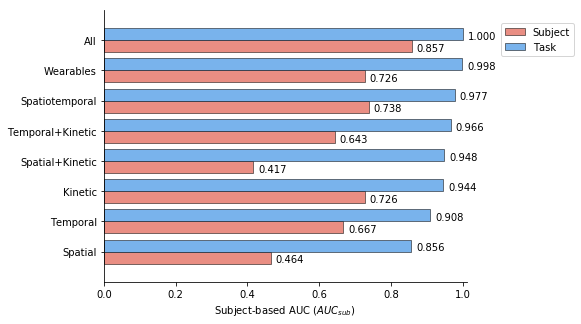

In [192]:
fi_sorted_walkAUC_subject_generalize2 = regressN_metrics_subject_generalize.loc['person_AUC_mean'].sort_values()
fi_sorted_walkAUC2 = regressN_metrics.loc['person_AUC'].sort_values()

data_display_names = {regressN_metrics.columns[i]:xticklabels[i] for i in range(8)}
data_display_names_sorted = [data_display_names[x] for x in fi_sorted_walkAUC2.index]

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

plt.figure(figsize = (6.5, 5))
sns.despine(offset=1)
# ax = sns.barplot(x = fi_sorted_walkAUC_subject_generalize.values, y = fi_sorted_walkAUC_subject_generalize.index, color ='#66b3ff', linewidth = 0.5, \
#                  edgecolor = 'k')
# ax = sns.catplot(y='data', x='fi', hue='model', data=feature_imp, kind='bar')
ax = sns.barplot(x = 'fi', y = 'data', hue = 'model', data = feature_imp, palette= ['salmon', '#66b3ff'], linewidth = 0.5, \
                 edgecolor = 'k', hue_order = ['MLP', 'GBM'])
for p in ax.patches:
    ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()-0.2),
                xytext=(5, 7), textcoords='offset points')
# plt.axvline(x=1, color = 'r', alpha = 0.7)

plt.yticks(np.arange(8), data_display_names_sorted)
plt.ylim(-1,8)
plt.xlim(0, 1.01)
plt.xlabel(r'Subject-based AUC ($AUC_{sub}$)')
plt.ylabel('')
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles, ['Subject', 'Task'], loc = 'upper right', bbox_to_anchor=(1.31, 0.97))
# plt.title('Feature importance', fontsize = 14)
plt.savefig(path+ '..//viz//combined_feature_importance_GBM_MLP_all8Data.png', dpi = 250, bbox_inches='tight')
plt.show()

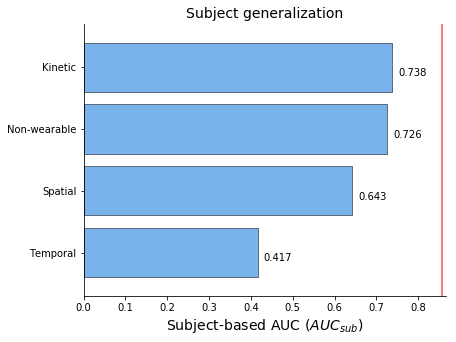

In [77]:
fi_sorted_walkAUC_reduced_subject_generalize = regressN_metrics_subject_generalize.loc['person_AUC_mean'][3:7].sort_values()

reduced_labels = ['T+K', 'S+K', 'S+T', 'Kinetic', 'Temporal', 'Spatial', 'Non-wearable', 'All']
data_display_names = {regressN_metrics_subject_generalize.columns[i]:reduced_labels[i] for i in range(8)}
data_display_names_sorted = [data_display_names[x] for x in fi_sorted_walkAUC_reduced_subject_generalize.index]

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

plt.figure(figsize = (6.5, 5))
sns.despine(offset=1)
ax = sns.barplot(x = fi_sorted_walkAUC_reduced_subject_generalize.values, y = fi_sorted_walkAUC_reduced_subject_generalize.index, color ='#66b3ff', linewidth = 0.5, \
                 edgecolor = 'k')
for p in ax.patches:
    ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(6, 16), textcoords='offset points')
plt.axvline(x=0.857, color = 'r', alpha = 0.7)

plt.yticks(np.arange(4), data_display_names_sorted)
plt.ylim(-0.7,3.7)
plt.xlim(0, max(fi_sorted_walkAUC_subject_generalize.values)+0.01)
plt.xlabel(r'Subject-based AUC ($AUC_{sub}$)', fontsize = 14)
plt.title('Subject generalization', fontsize = 14)
plt.savefig(path+ '..//person_generalize//person_generalize_feature_importance_barplot_reduced_data_MLP.png', dpi = 250, bbox_inches='tight')
plt.show()